#### Preludio

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn.objects as so
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

import ipywidgets as iwy

resistencias = [201, 313, 402, 509, 600, 701, 800, 900]  # Ohm

difraccion = lambda p, a, b, p0: 1 / ((a / (p0 - p)**2) + b)**0.5
popt_calibracion_ldo = [1.50552530e+00, 8.16313771e-07, 1.71174781e+03]

ldo_min = 400  # nm
ldo_max = 700  # nm
step = 2  # nm

In [31]:
from os.path import exists
if not exists('./calibracion_intensidad/'):
    !pip install -q gdown
    from gdown import download_folder
    id = '1wdeCeB2VlREgkuJntKVKx_VylohtFNk3'
    download_folder(f'https://drive.google.com/drive/folders/{id}', quiet=False, use_cookies=False)

#### Graficar señales

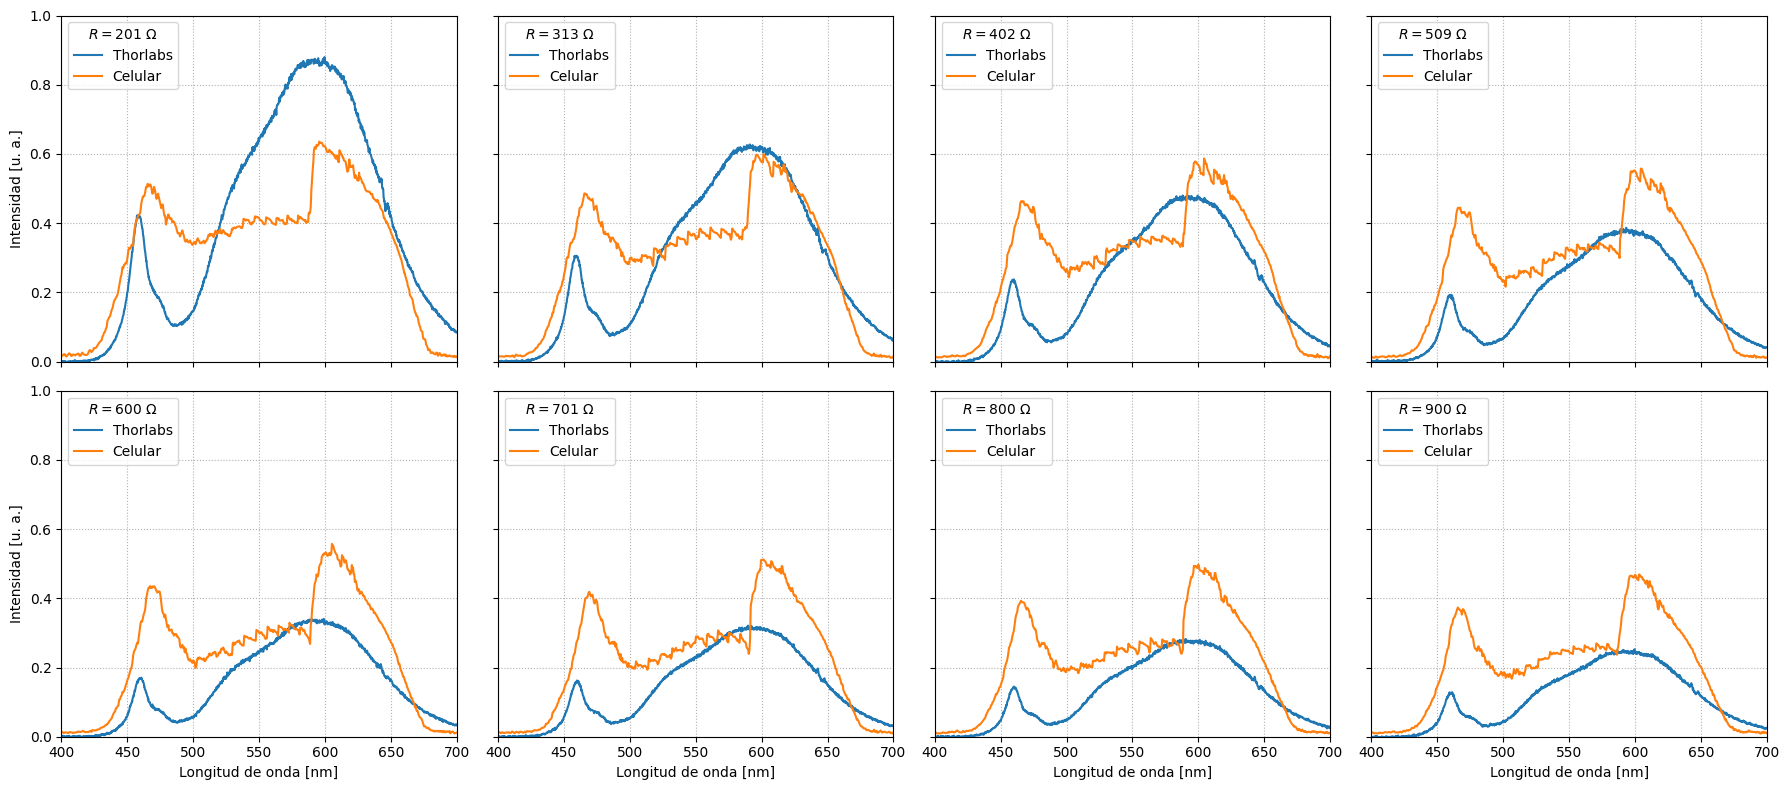

In [32]:
fig, ax = plt.subplots(2, 4, figsize=(18, 8), sharey=True, sharex=True)

for i in range(2):
    for j in range(4):
        n = i * 4 + j
        R = resistencias[n]

        # DATOS THORLABS
        ldo_e, i_e = np.loadtxt(f'./calibracion_intensidad/blanco_intensidad_thorlabs_{R}.csv',
                                skiprows=53, delimiter=',', unpack=True)

        i_e = i_e[(ldo_e >= ldo_min) & (ldo_e <= ldo_max)]
        ldo_e = ldo_e[(ldo_e >= ldo_min) & (ldo_e <= ldo_max)]

        # DATOS CELULAR
        df_c = pd.read_csv(f'./calibracion_intensidad/blanco_intensidad_celular_{R}.csv', skiprows=3,
                        names=['Nro. de pixel','R_blanco','G_blanco','B_blanco','R_muestra','G_muestra','B_muestra'])

        df_c['gris promedio'] = df_c.iloc[:, 1:].mean(axis=1)

        df_c['ldo'] = difraccion(df_c['Nro. de pixel'].to_numpy(), *popt_calibracion_ldo)

        df_c = df_c.sort_values(by='ldo')

        df_c = df_c[(df_c['ldo'] >= ldo_min) & (df_c['ldo'] <= ldo_max)]

        ldo_c = df_c['ldo'].to_numpy()
        i_c = df_c['gris promedio'].to_numpy()

        # GRAFICO
        # ax[i, j].set_title(f'$R = {R} \ \Omega$')

        ax[i, j].plot(ldo_e, i_e, label='Thorlabs')
        ax[i, j].plot(ldo_c, i_c, label='Celular')

        if i == 1:
            ax[i, j].set_xlabel('Longitud de onda [nm]')
        if j == 0:
            ax[i, j].set_ylabel('Intensidad [u. a.]')

        ax[i, j].legend(title=f'$R = {R} \ \Omega$', loc='upper left')


for ax_i in ax:
    for ax_j in ax_i:
        ax_j.grid(ls=':')
        ax_j.set_xlim(ldo_min, ldo_max)
        ax_j.set_ylim(0, 1)

plt.tight_layout()
plt.show()

#### Primer intento

In [33]:
longitudes_de_onda = np.arange(ldo_min, ldo_max, step)
bins = np.arange(ldo_min, ldo_max + step, step)
amplitudes_celular = []
amplitudes_thorlabs = []
errores_celular = []
errores_thorlabs = []

for R in resistencias:
    # DATOS THORLABS
    ldo_e, i_e = np.loadtxt(f'./calibracion_intensidad/blanco_intensidad_thorlabs_{R}.csv',
                            skiprows=53, delimiter=',', unpack=True)

    df_e = pd.DataFrame({'ldo': ldo_e, 'i': i_e})

    # DATOS CELULAR
    df_c = pd.read_csv(f'./calibracion_intensidad/blanco_intensidad_celular_{R}.csv', skiprows=3,
                       names=['Nro. de pixel','R_blanco','G_blanco','B_blanco','R_muestra','G_muestra','B_muestra'])

    df_c['gris promedio'] = df_c.iloc[:, 1:].mean(axis=1)

    df_c['ldo'] = difraccion(df_c['Nro. de pixel'].to_numpy(), *popt_calibracion_ldo)

    df_c = df_c.sort_values(by='ldo')

    df_c = df_c[(df_c['ldo'] >= 400) & (df_c['ldo'] <= 700)]

    # BINEADO
    i_e = []
    std_e = []
    i_c = []
    std_c = []
    for i in range(1, len(bins)):
        i_e.append(df_e[(df_e['ldo'] >= bins[i-1]) & (df_e['ldo'] < bins[i])]['i'].mean())
        i_c.append(df_c[(df_c['ldo'] >= bins[i-1]) & (df_c['ldo'] < bins[i])]['gris promedio'].mean())
        std_c.append(df_c[(df_c['ldo'] >= bins[i-1]) & (df_c['ldo'] < bins[i])]['gris promedio'].std())
        std_e.append(df_e[(df_e['ldo'] >= bins[i-1]) & (df_e['ldo'] < bins[i])]['i'].std())

    amplitudes_celular.append(i_c)
    errores_celular.append(std_c)
    amplitudes_thorlabs.append(i_e)
    errores_thorlabs.append(std_e)

amplitudes_celular = np.array(amplitudes_celular).T
errores_celular = np.array(errores_celular).T
amplitudes_thorlabs = np.array(amplitudes_thorlabs).T
errores_thorlabs = np.array(errores_thorlabs).T

In [34]:
def graficar(i=0):
    fig, ax = plt.subplots()

    # Línea base gris
    # ax.plot(amplitudes_celular[i], amplitudes_thorlabs[i], '--', c='grey', alpha=0.5)

    # Usamos una colormap por resistencia para colorear cada punto individual
    norm = plt.Normalize(min(resistencias), max(resistencias))
    cmap = plt.get_cmap('plasma')

    for j, (x, y, xerr, yerr, r) in enumerate(zip(amplitudes_celular[i],
                                                  amplitudes_thorlabs[i],
                                                  errores_celular[i],
                                                  errores_thorlabs[i],
                                                  resistencias)):
        color = cmap(norm(r))
        label = 'Datos' if j == 0 else None  # solo el primero tiene etiqueta
        ax.errorbar(x, y, xerr=xerr, yerr=yerr,
                    fmt='o', color=color, ecolor=color, elinewidth=1, capsize=3, label=label)

    popt_calibracion_intensidad, pcov = np.polyfit(amplitudes_celular[i], amplitudes_thorlabs[i],
                                                   w=(1/errores_thorlabs[i])**2, deg=3, cov=True)

    x_fino = np.linspace(min(amplitudes_celular[i]), max(amplitudes_celular[i]), 500)
    ax.plot(x_fino, np.poly1d(popt_calibracion_intensidad)(x_fino), 'k-', label='Ajuste')

    # Barra de color manual
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # requerido para evitar advertencias
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Resistencia $[\Omega]$')

    ax.set_xlabel('Nivel de gris [u. a.]')
    ax.set_ylabel('Intensidad [u. a.]')
    ax.grid(ls=':')
    ax.legend()

    plt.show()

iwy.interact(graficar, i=(0, len(longitudes_de_onda)-1, 1));

interactive(children=(IntSlider(value=0, description='i', max=149), Output()), _dom_classes=('widget-interact'…

In [35]:
popts = []
pcovs = []
for i in range(len(amplitudes_celular)):
    # popt, pcov = np.polyfit(amplitudes_celular[i], amplitudes_thorlabs[i],
    #                         w=(1/errores_thorlabs[i])**2, deg=3, cov=True)
    popt, pcov = np.polyfit(amplitudes_celular[i], amplitudes_thorlabs[i],
                            deg=3, cov=True)
    popts.append(popt)
    pcovs.append(pcov)

In [36]:
def calibracion_intensidad(popts, amplitudes):
    lito = []
    for i in range(len(popts)):
        lito.append(np.poly1d(popts[i])(amplitudes[i]))
    return np.array(lito)

celular_calibrado = calibracion_intensidad(popts, amplitudes_celular.T[0])

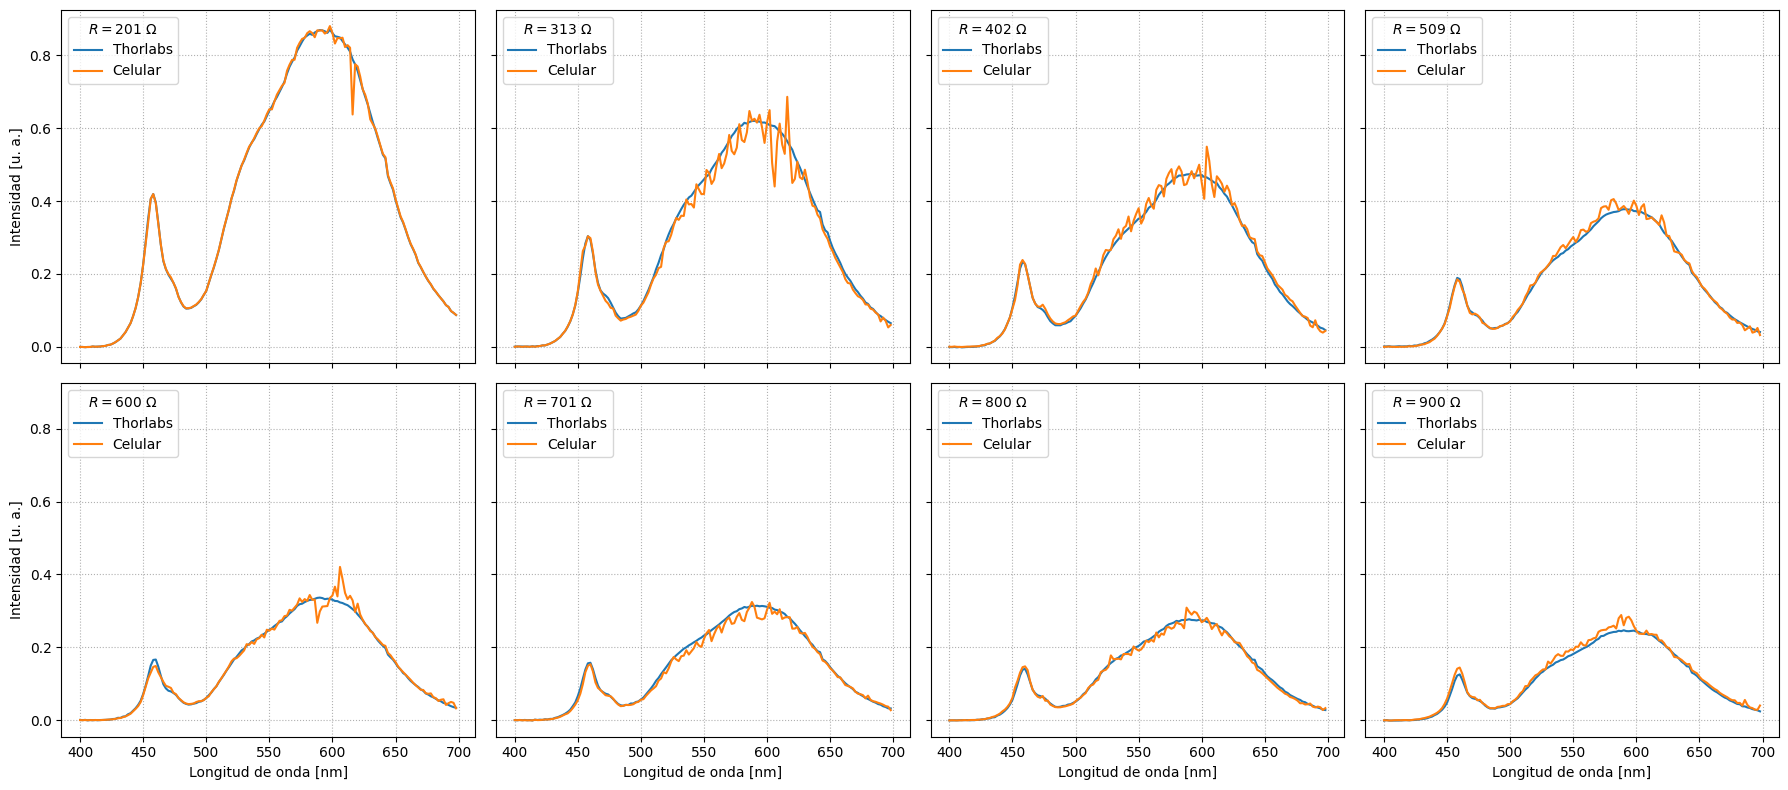

In [37]:
bins = np.arange(ldo_min, ldo_max + step, step)
longitudes_de_onda = bins[:-1]

fig, ax = plt.subplots(2, 4, figsize=(18, 8), sharey=True, sharex=True)

for i in range(2):
    for j in range(4):
        n = i * 4 + j
        R = resistencias[n]

        # DATOS THORLABS
        ldo_e, i_e = np.loadtxt(f'./calibracion_intensidad/blanco_intensidad_thorlabs_{R}.csv',
                                skiprows=53, delimiter=',', unpack=True)

        i_e = i_e[(ldo_e >= ldo_min) & (ldo_e <= ldo_max)]
        ldo_e = ldo_e[(ldo_e >= ldo_min) & (ldo_e <= ldo_max)]
        df_e = pd.DataFrame({'ldo': ldo_e, 'i': i_e})

        # DATOS CELULAR
        df_c = pd.read_csv(f'./calibracion_intensidad/blanco_intensidad_celular_{R}.csv', skiprows=3,
                           names=['Nro. de pixel','R_blanco','G_blanco','B_blanco','R_muestra','G_muestra','B_muestra'])

        df_c['gris promedio'] = df_c.iloc[:, 1:].mean(axis=1)

        df_c['ldo'] = difraccion(df_c['Nro. de pixel'].to_numpy(), *popt_calibracion_ldo)

        df_c = df_c.sort_values(by='ldo')

        df_c = df_c[(df_c['ldo'] >= ldo_min) & (df_c['ldo'] <= ldo_max)]

        # ldo_c = df_c['ldo'].to_numpy()
        # i_c = df_c['gris promedio'].to_numpy()

        # BINEADO
        i_e = []
        std_e = []
        i_c = []
        std_c = []
        for k in range(1, len(bins)):
            i_e.append(df_e[(df_e['ldo'] >= bins[k-1]) & (df_e['ldo'] < bins[k])]['i'].mean())
            i_c.append(df_c[(df_c['ldo'] >= bins[k-1]) & (df_c['ldo'] < bins[k])]['gris promedio'].mean())
            std_c.append(df_c[(df_c['ldo'] >= bins[k-1]) & (df_c['ldo'] < bins[k])]['gris promedio'].std())
            std_e.append(df_e[(df_e['ldo'] >= bins[k-1]) & (df_e['ldo'] < bins[k])]['i'].std())

        intensidad_calibrada = []
        for k in range(len(longitudes_de_onda)):
            intensidad_calibrada.append(np.poly1d(popts[k])(i_c[k]))

        # GRAFICO
        # ax[i, j].set_title(f'$R = {R} \ \Omega$')

        ax[i, j].plot(longitudes_de_onda, i_e, label='Thorlabs')
        ax[i, j].plot(longitudes_de_onda, intensidad_calibrada, label='Celular')

        if i == 1:
            ax[i, j].set_xlabel('Longitud de onda [nm]')
        if j == 0:
            ax[i, j].set_ylabel('Intensidad [u. a.]')

        ax[i, j].legend(title=f'$R = {R} \ \Omega$', loc='upper left')


for ax_i in ax:
    for ax_j in ax_i:
        ax_j.grid(ls=':')
        # ax_j.set_xlim(ldo_min, ldo_max)
        # ax_j.set_ylim(0, 1)

plt.tight_layout()
plt.show()